# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from PIL import Image, ImageDraw, ImageFont, ImageStat
import glob
import pandas as pd
import tensorflow as tf
from collections import Counter
import numpy as np
import re

In [2]:
dataset = get_dataset("/home/workspace/data/waymo/training_and_validation/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 97
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # ADD CODE HERE
    %matplotlib notebook
    fig, axs = plt.subplots(3,4, figsize = (10,10))
    column = 1
    row = 1
    
    for data in batch:
        image = data['image'].numpy()
        gt_bbox = data['groundtruth_boxes'].numpy()
        gt_classes = data['groundtruth_classes'].numpy()
        #file = data[op]

        w,h,_ = image.shape

        colors = ['r', 'b', 'g', 'k', 'c']

        axs[row-1, column-1].imshow(image)

        for cl, bbox in zip(gt_classes, gt_bbox):
            y1,x1,y2,x2 = bbox
            x1 *= w
            x2 *= w
            y1 *= h
            y2 *= h
            rect = Patches.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor = colors[cl], facecolor = 'None')
            axs[row-1, column-1].add_patch(rect)

        if column % 4 == 0:
         #   print('Reset column')
            row += 1
            column = 1
        else:
          #  print('Increase column')
            column += 1
    plt.tight_layout()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

<IPython.core.display.Javascript object>


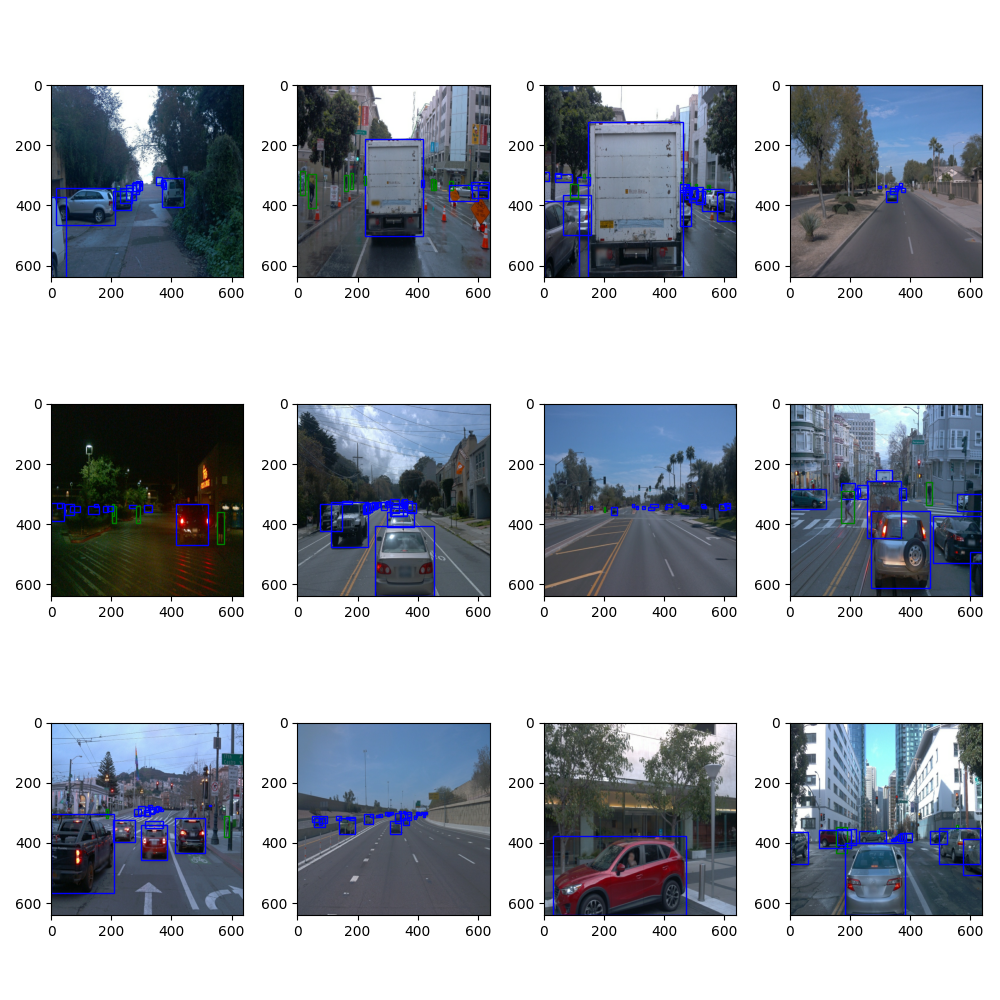

In [4]:
## STUDENT SOLUTION HERE
dataset = dataset.shuffle(100)
display_instances(dataset.take(12))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

## Calculate Statistics
In order to better understand the dataset we will calculate some statistics and plot them as histograms:
 - number of vehicles
 - number of pedestrians
 - number of cyclists
 - the perceived brightness

In [5]:
def get_perceived_brightness(image):
    # convert image to PIL object to calculate the perceived brightness using the formula 
    # (0.21 x R) + (0.72 x G) + (0.07 x B)
    # INPUT: we expect the input as a numpy array
    im = Image.fromarray(np.uint8(image))
    stat = ImageStat.Stat(im)
    r,g,b = stat.mean
    return np.sqrt((0.21*(r**2) + 0.72*(g**2) + 0.07*(b**2)))

In [6]:
def num_objects(path_tfrecord):
    '''This function counts the number of classes that are present in a tfrecord
       and returns a dic of the classes values
    '''
    # Read the information from a single tfrecord
    raw_dataset = tf.data.TFRecordDataset(path_tfrecord)
    # Initialize Counter of Classes to zero
    count_classes = { 1: 0, 2: 0,  4: 0 }
    brightness = []
    
    # Iterate to each element of the tfrecord
    for i, raw_record in enumerate(raw_dataset):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        # Iterate to each feature item from the tfrecord
        for k, v in example.features.feature.items():
            # extract the information from the class labels
            if k == 'image/object/class/label':
                values = v.int64_list.value
                count_classes= Counter(count_classes)+ Counter(values)
                
            if k == 'image/encoded':
                # the image is encoded as bytes and originally a jped. For that reason we use the tensorflow
                # method tf.image.decode_jpeg from the tf.io API
                image = tf.image.decode_jpeg(v.bytes_list.value[0]).numpy()
                brightness.extend([get_perceived_brightness(image)])
                
                
        frames = i
    brightness = sum(brightness)/len(brightness)
    return count_classes,frames, brightness


In [7]:
classes_list = []
frames_list = []
fileName_list = []
brightness_list = []

for file in glob.glob('/data/waymo/segment*.tfrecord'):
    count_classes, frames, brightness = num_objects(file)
    classes_list.extend([count_classes])
    frames_list.extend([frames])
    brightness_list.extend([brightness])
    
    m = re.search('segment-\d*.*', file)
    file_name = m[0]
    fileName_list.extend([file_name])
    


Create a dataframe out of the information for simpler handling

In [8]:
vehicles = []
pedestrians = []
cyclists = []
for idx in range(len(fileName_list)):
    vehicles.extend([classes_list[idx][1]])
    pedestrians.extend([classes_list[idx][2]])
    cyclists.extend([classes_list[idx][4]])

In [9]:
dict = {'Vehicles': vehicles,
       'Pedestrians': pedestrians,
       'Cyclists': cyclists,
       'brightness_mean': brightness_list,
       'fileName': fileName_list,
       'frames': frames_list}

In [10]:
df = pd.DataFrame(dict)
df.set_index('fileName', inplace = True)

In [11]:
pd.set_option('display.max_rows', None)
df

,Vehicles,Pedestrians,Cyclists,brightness_mean,frames
fileName,,,,,
segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord,5923,872,0,98.620478,198
segment-11486225968269855324_92_000_112_000_with_camera_labels.tfrecord,2570,9,0,97.808986,198
segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord,6248,2586,144,117.985650,198
segment-10226164909075980558_180_000_200_000_with_camera_labels.tfrecord,4239,1546,0,46.708783,197
segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord,3703,3545,20,111.193225,198
segment-11343624116265195592_5910_530_5930_530_with_camera_labels.tfrecord,4109,171,0,101.942254,198
segment-10786629299947667143_3440_000_3460_000_with_camera_labels.tfrecord,3958,0,0,130.210270,197
segment-10664823084372323928_4360_000_4380_000_with_camera_labels.tfrecord,3032,4163,236,91.939795,197
segment-10455472356147194054_1560_000_1580_000_with_camera_labels.tfrecord,6645,711,0,102.486055,198


## Figures

In [12]:
%matplotlib notebook
import seaborn as sns
fig, axs = plt.subplots(3,1, figsize = (8,8))
sns.histplot(df['Vehicles'], ax = axs[0])
sns.histplot(df['Pedestrians'], ax = axs[1])
sns.histplot(df['Cyclists'], ax = axs[2])
plt.tight_layout()

ModuleNotFoundError: No module named 'seaborn'

Out of the histogram values shown in the image above it can be observed that:
- The number of images with any given number of cars is well represented in the dataset
- Less represented are the pedestrian and cyclist classes. 

In [13]:
plt.figure()
sns.histplot(df['brightness_mean'])
plt.tight_layout()

<IPython.core.display.Javascript object>

In [14]:
df.sort_values(by='brightness_mean', inplace = True)

In [15]:
df_night = df[df['brightness_mean']<70]
num_night_scenes = len(df_night)
print("There are " + str(num_night_scenes) + ' night scenes')
df_night

There are 9 night scenes


,Vehicles,Pedestrians,Cyclists,brightness_mean,frames
fileName,,,,,
segment-10724020115992582208_7660_400_7680_400_with_camera_labels.tfrecord,491,36,116,17.243861,197
segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord,881,78,0,20.668780,197
segment-10082223140073588526_6140_000_6160_000_with_camera_labels.tfrecord,2799,539,0,21.981620,196
segment-12200383401366682847_2552_140_2572_140_with_camera_labels.tfrecord,1326,0,0,26.873929,198
segment-10975280749486260148_940_000_960_000_with_camera_labels.tfrecord,1079,0,0,28.281604,188
segment-10241508783381919015_2889_360_2909_360_with_camera_labels.tfrecord,1009,440,0,30.923921,197
segment-10107710434105775874_760_000_780_000_with_camera_labels.tfrecord,621,0,0,43.795894,198
segment-10226164909075980558_180_000_200_000_with_camera_labels.tfrecord,4239,1546,0,46.708783,197
segment-10584247114982259878_490_000_510_000_with_camera_labels.tfrecord,1155,0,0,52.578842,196


The images with lower brightness might correspond to night images. Let's check it plotting the first frame of the scene with the highest contrast

In [26]:
file2load = 'data/waymo/training_and_validation/' + df_night.iloc[0].name

<IPython.core.display.Javascript object>


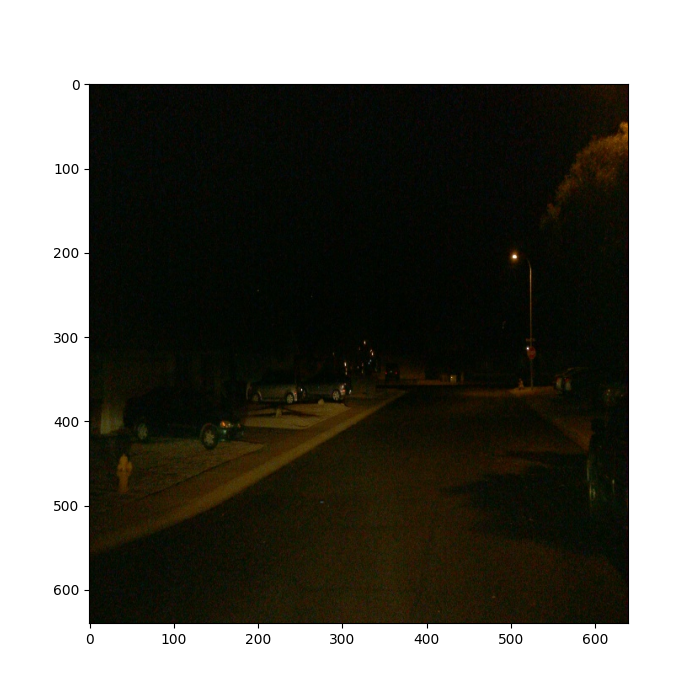

In [27]:
# Read the information from a single tfrecord
raw_dataset = tf.data.TFRecordDataset(file2load)
    
# Iterate to each element of the tfrecord
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    # Iterate to each feature item from the tfrecord
    for k, v in example.features.feature.items():
        # extract the information from the class labels                
            if k == 'image/encoded':
                # the image is encoded as bytes and originally a jped. For that reason we use the tensorflow
                # method tf.image.decode_jpeg from the tf.io API
                image = tf.image.decode_jpeg(v.bytes_list.value[0]).numpy()
                plt.figure(figsize = (7,7))
                plt.imshow(image)

--------------------------------------------------------------

## Creation of Splits

For the creation of the different splits we will shuffle the data using scikit-learn function `shuffle`

In [28]:
from sklearn.utils import shuffle
df = shuffle(df)
df

,Vehicles,Pedestrians,Cyclists,brightness_mean,frames
fileName,,,,,
segment-12012663867578114640_820_000_840_000_with_camera_labels.tfrecord,5672,844,0,114.704946,198
segment-11379226583756500423_6230_810_6250_810_with_camera_labels.tfrecord,25,157,23,111.132354,197
segment-1208303279778032257_1360_000_1380_000_with_camera_labels.tfrecord,1869,0,0,94.080743,197
segment-10734565072045778791_440_000_460_000_with_camera_labels.tfrecord,466,273,0,83.659898,198
segment-10927752430968246422_4940_000_4960_000_with_camera_labels.tfrecord,7326,600,0,109.784603,196
segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord,3703,3545,20,111.193225,198
segment-10975280749486260148_940_000_960_000_with_camera_labels.tfrecord,1079,0,0,28.281604,188
segment-1172406780360799916_1660_000_1680_000_with_camera_labels.tfrecord,2354,249,0,88.969747,197
segment-11918003324473417938_1400_000_1420_000_with_camera_labels.tfrecord,2637,387,155,118.238478,197


We will take to start with the classical approach of 60% / 20% / 20% and see how the distributions are

In [24]:
number_tf_records = len(df)
number_tf_records

100

In [25]:
# calculate lengths
train_len = int(number_tf_records * 0.6)
val_len = int(number_tf_records * 0.2)

# extract dataFrames
df_train = df[:train_len]
df_val = df[train_len: (train_len + val_len)]
df_test = df[(train_len + val_len):]

Plot the distributions

<IPython.core.display.Javascript object>


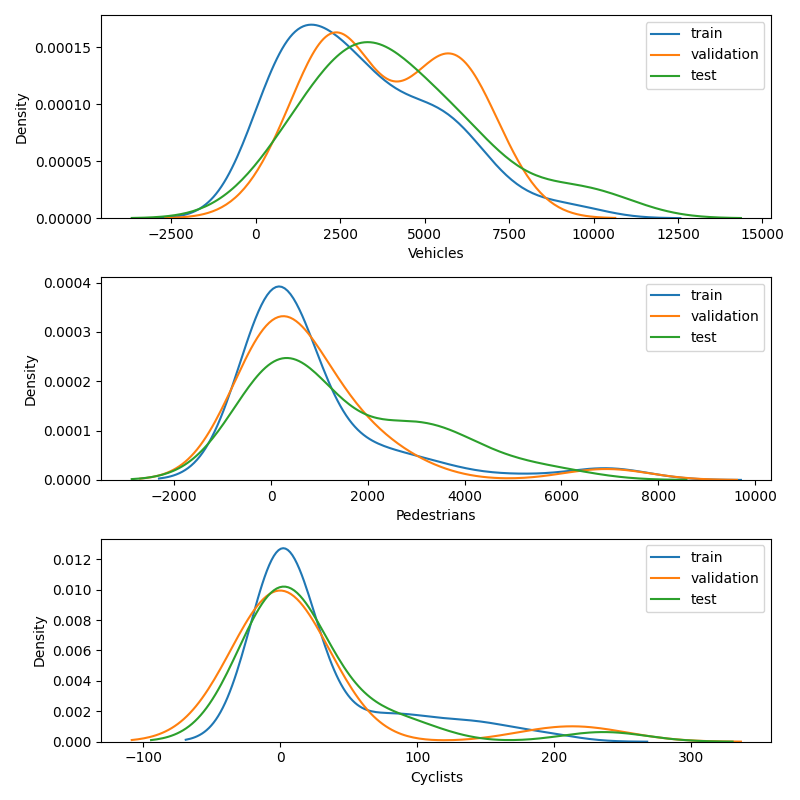

In [36]:
fig, axs = plt.subplots(3,1,figsize = (8,8))
sns.kdeplot(df_train['Vehicles'], ax = axs[0], label = 'train')
sns.kdeplot(df_val['Vehicles'], ax = axs[0], label = 'validation')
sns.kdeplot(df_test['Vehicles'], ax = axs[0], label = 'test')
axs[0].legend()

sns.kdeplot(df_train['Pedestrians'], ax = axs[1], label = 'train')
sns.kdeplot(df_val['Pedestrians'], ax = axs[1], label = 'validation')
sns.kdeplot(df_test['Pedestrians'], ax = axs[1], label = 'test')
axs[1].legend()

sns.kdeplot(df_train['Cyclists'], ax = axs[2], label = 'train')
sns.kdeplot(df_val['Cyclists'], ax = axs[2], label = 'validation')
sns.kdeplot(df_test['Cyclists'], ax = axs[2], label = 'test')
axs[2].legend()

plt.tight_layout()

<IPython.core.display.Javascript object>


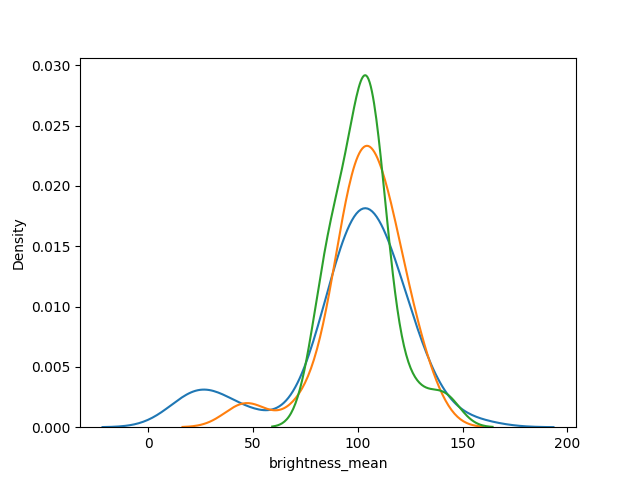

<AxesSubplot:xlabel='brightness_mean', ylabel='Density'>

In [37]:
plt.figure()
sns.kdeplot(df_train['brightness_mean'])
sns.kdeplot(df_val['brightness_mean'])
sns.kdeplot(df_test['brightness_mean'])

## Conclusions

From the probability distributions it can be observed that the shuffle procedure created similar datasets for training, validation and test. It will be necessary to evaluate later on, whether it is sufficient or if we have to make use of data augmentation to increase the features that are currently under-represented


In [38]:
# Save the split in a file for later use in create_split.py

# train
file = open('train.txt', 'w')
for row in range(len(df_train)):
    file.write(df_train.iloc[row].name + '\n')
file.close()

# validation
file = open('validation.txt', 'w')
for row in range(len(df_val)):
    file.write(df_val.iloc[row].name + '\n')
file.close()

# test
file = open('test.txt', 'w')
for row in range(len(df_test)):
    file.write(df_test.iloc[row].name + '\n')
file.close()

In [39]:
file = open('test.txt', 'r')
for line in file:
    print(line[:-1])

segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord
segment-10923963890428322967_1445_000_1465_000_with_camera_labels.tfrecord
segment-10444454289801298640_4360_000_4380_000_with_camera_labels.tfrecord
segment-10072140764565668044_4060_000_4080_000_with_camera_labels.tfrecord
segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord
segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord
segment-10940952441434390507_1888_710_1908_710_with_camera_labels.tfrecord
segment-10876852935525353526_1640_000_1660_000_with_camera_labels.tfrecord
segment-10391312872392849784_4099_400_4119_400_with_camera_labels.tfrecord
segment-1191788760630624072_3880_000_3900_000_with_camera_labels.tfrecord
segment-11060291335850384275_3761_210_3781_210_with_camera_labels.tfrecord
segment-10734565072045778791_440_000_460_000_with_camera_labels.tfrecord
segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord
segment-12174529769287588121_3